In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, shutil
import torch
import time
import warnings
from botorch.exceptions import BadInitialCandidatesWarning
import pdb
import matplotlib.pyplot as plt

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
import head
import numpy as np
from head.metrics import euclidean_dist
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.optim.optimize import optimize_acqf_discrete
from botorch.acquisition.monte_carlo import qUpperConfidenceBound
from botorch.acquisition.objective import LinearMCObjective
from matplotlib.cm import ScalarMappable

N_UVVIS_SAMPLES = 10
N_SAS_SAMPLES = 100
NUM_GRID_PERDIM = 100
BATCH_SIZE = 5
N_ITERATIONS = 10
NUM_RESTARTS = 20 
RAW_SAMPLES = 1024
N_INIT_SAMPLES = 10

R_mu = 20
R_sigma = 1e-2
SHAPE_PARAM = 0.67
SPECTRA = 'saxs'

expt = {}
EXPT_ID = 0

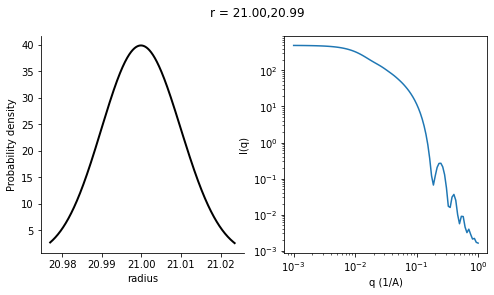

In [3]:
sim = head.EmulatorMultiShape()
sim.make_structure(r_mu=R_mu,r_sigma=R_sigma)

fig, axs = plt.subplots(1,2,figsize=(4*2,4))

sim.plot_radii(axs[0])
axs[0].set_xlabel('radius')
axs[0].set_ylabel('Probability density')

if SPECTRA=='saxs':
    xt, yt = sim.get_saxs(shape_param = SHAPE_PARAM, n_samples=N_SAS_SAMPLES)
    axs[1].loglog(xt, yt)
    plt.setp(axs[1], xlabel='q (1/A)', ylabel='I(q)')
elif SPECTRA=='uvvis':
    xt, yt = sim.get_uvvis(shape_param = 0.67, n_samples=N_UVVIS_SAMPLES)
    axs[1].plot(xt, yt)
    plt.setp(axs[1], xlabel='wavelength (nm))', ylabel=r'I($\lambda$)')
    
fig.suptitle('r = '+','.join('%.2f'%i for i in sim.radii))
plt.show()

In [4]:
# define search space

class MinMaxScaler:
    def __init__(self, low, high):
        self.low = low
        self.high = high
        
    def transform(self, r):
        return self.low + r*(self.high-self.low)
    
    def inverse(self, x):
        return (x-self.low)/(self.high-self.low)


r_mu = MinMaxScaler(5,50)
r_sigma = MinMaxScaler(0,1)
shape_param = MinMaxScaler(0,1)
bounds = torch.tensor([[0,1]]*3).T.to(**tkwargs)

In [5]:
def oracle(x):
    """Scoring function at a given input location
    Uses the simulator sim to generate response spectra at a given locations
    and return a similarity score to target spectra
    """
    global EXPT_ID
    x_np = x.cpu().numpy()    
    sim.make_structure(r_mu=r_mu.transform(x_np[0]),
                       r_sigma=r_sigma.transform(x_np[1]))
    if SPECTRA=='saxs':
        xi, yi = sim.get_saxs(shape_param = shape_param.transform(x_np[2]), 
                              n_samples=N_SAS_SAMPLES)
        dist = euclidean_dist(np.log10(yi),np.log10(yt))
    elif SPECTRA=='uvvis':
        xi, yi = sim.get_uvvis(shape_param = shape_param.transform(x_np[2]), 
                               n_samples=N_UVVIS_SAMPLES)
        dist = euclidean_dist(yi,yt)
        
    expt[EXPT_ID] = [xi, yi, dist]
    EXPT_ID += 1
    
    return torch.tensor([dist])

def batch_oracle(x):
    out = []
    for xi in x.squeeze(1):
        out.append(oracle(xi))
    return torch.stack(out, dim=0).to(**tkwargs)

In [6]:
from botorch.utils.sampling import draw_sobol_samples

def draw_random_batch(n_samples=6):
    train_x = draw_sobol_samples(
        bounds=bounds,n=1, q=n_samples, 
        seed=torch.randint(2021, (1,)).item()
    ).squeeze(0)
    train_obj = batch_oracle(train_x)
    return train_x, train_obj


train_x, train_obj = draw_random_batch(n_samples=N_INIT_SAMPLES)
print('Generated %d samples randomly'%N_INIT_SAMPLES, train_x.shape, train_obj.shape)
for i in range(N_INIT_SAMPLES):
    print('%d\t%s\t%s'%(i, train_x[i,...].numpy(), train_obj[i,...].numpy()))

Generated 10 samples randomly torch.Size([10, 3]) torch.Size([10, 1])
0	[0.58673614 0.93958032 0.08161592]	[-4.06959534]
1	[0.24940628 0.03160606 0.01525604]	[-7.69836235]
2	[0.51482648 0.05463553 0.81470031]	[-3.42411685]
3	[0.51419568 0.19683231 0.81610739]	[-3.43436766]
4	[0.31332341 0.17136286 0.99942315]	[-0.74865061]
5	[0.72253668 0.86687666 0.00980307]	[-4.25136375]
6	[0.83463728 0.27737948 0.58639735]	[-5.40490055]
7	[0.61506891 0.84622365 0.9933244 ]	[-4.09162235]
8	[0.35960722 0.86713392 0.43482471]	[-5.42266655]
9	[0.40463302 0.01355203 0.97225732]	[-2.21790028]


In [7]:
def initialize_model(train_x, train_obj):
    # define models for objective and constraint
    model = SingleTaskGP(train_x, train_obj, 
    outcome_transform=Standardize(m=train_obj.shape[-1]))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

mll, model = initialize_model(train_x, train_obj)

# 3. Define acqusition function
obj = LinearMCObjective(weights=torch.tensor([1.0]).to(**tkwargs))


In [8]:
from botorch.optim.optimize import optimize_acqf

def selector(f, q = BATCH_SIZE):
    new_x, _ = optimize_acqf(
        acq_function=f,
        bounds=bounds,
        q=q,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES, 
        sequential=False,
    )
    new_obj = batch_oracle(new_x)
    return new_x, new_obj

In [9]:
torch.manual_seed(2021)
import pdb

# run N_ITERATIONS rounds of BayesOpt after the initial random batch
print('Sampled ID \t Locations \t Objectives')
for iteration in range(1, N_ITERATIONS + 1):    
    print('Iteration : %d/%d'%(iteration, N_ITERATIONS))
    # fit the models
    fit_gpytorch_model(mll)

    # define the acquisition module
    acquisition = qUpperConfidenceBound(model, beta=0.1, objective=obj)
    
    # optimize acquisition functions and get new observations
    new_x, new_obj = selector(acquisition)
    for i in range(BATCH_SIZE):
        print('%d\t%s\t%s'%(i, new_x[i,...].numpy(), new_obj[i,...].numpy()))

    # update training points
    train_x = torch.cat([train_x, new_x])
    train_obj = torch.cat([train_obj, new_obj])

    # re-initialize
    mll, model = initialize_model(train_x, train_obj)

    best = train_obj.max(axis=0).values
    print('Best %.2f'%(best))

Sampled ID 	 Locations 	 Objectives
Iteration : 1/10
0	[0.90418494 0.56534068 0.289346  ]	[-5.13792372]
1	[0.32815206 0.98495027 0.24369515]	[-5.96795988]
2	[0.24215033 0.80800122 0.87081084]	[-2.89079261]
3	[0.18863189 0.19315705 1.        ]	[-3.77476883]
4	[0.23144686 0.25561842 1.        ]	[-3.04640412]
Best -0.75
Iteration : 2/10
0	[0.23509221 0.55376967 0.66641101]	[-2.98612452]
1	[0.88034544 0.92282155 0.06604138]	[-5.15545225]
2	[0.32712034 0.40807384 0.63760546]	[-0.05607165]
3	[0.17619613 0.74842018 0.9055874 ]	[-3.413872]
4	[0.33256409 0.24311095 1.        ]	[-0.1299326]
Best -0.06
Iteration : 3/10
0	[0.22448707 0.13620172 0.1629264 ]	[-8.06458664]
1	[0.79138877 0.41983377 0.16336112]	[-4.42340803]
2	[0.41968956 0.96038826 0.93229838]	[-2.26130915]
3	[0.46920845 0.23713232 0.29644609]	[-4.17205954]
4	[0.34668928 0.3434988  0.80521446]	[-0.45249525]
Best -0.06
Iteration : 4/10
0	[0.65398544 0.50886028 0.19211635]	[-4.14019299]
1	[0.59694942 0.66702588 0.36473402]	[-4.07083321]

In [10]:
# obtain best sample and corresponding objective
from botorch.acquisition import PosteriorMean
from botorch.acquisition.objective import ScalarizedObjective
objective = ScalarizedObjective(weights=torch.tensor([1.0]).to(**tkwargs))

print('Actual target : ', [R_mu, R_sigma])
opt_x, opt_obj = selector(PosteriorMean(model, objective=objective), q=1)
opt_x = opt_x.cpu().numpy().squeeze()
opt_rmu = r_mu.transform(opt_x[0])
opt_rsigma = r_sigma.transform(opt_x[1])
opt_shape_param = shape_param.transform(opt_x[2])
print('Optimal location: ',[opt_rmu, opt_rsigma, opt_shape_param],
      '\nOptimal model scores: ', opt_obj.numpy())

Actual target :  [20, 0.01]
Optimal location:  [17.162629173801804, 0.32450560646719806, 1.0] 
Optimal model scores:  [[-2.262784]]


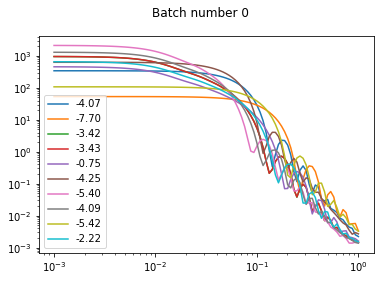

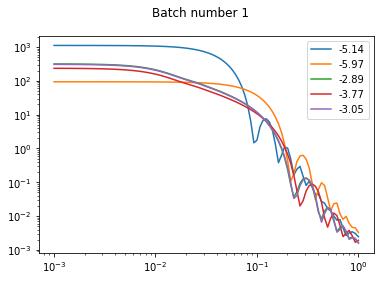

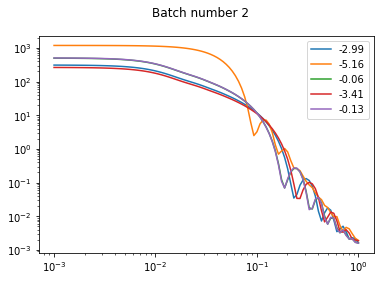

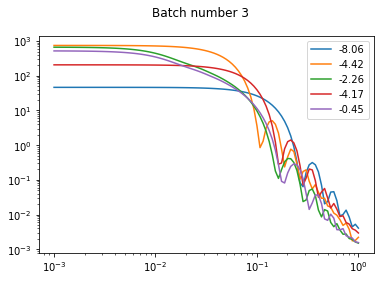

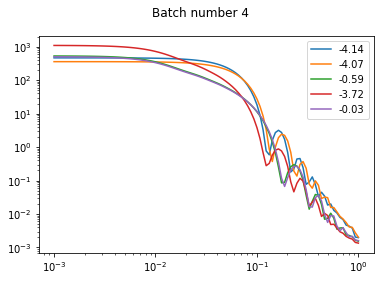

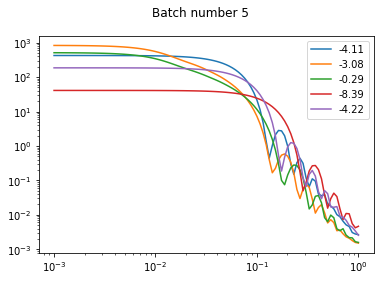

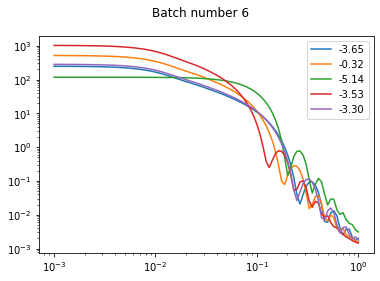

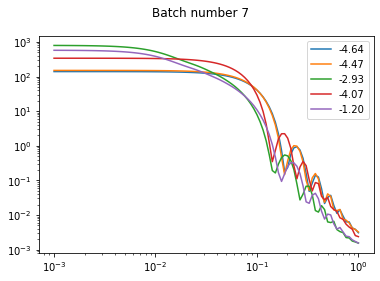

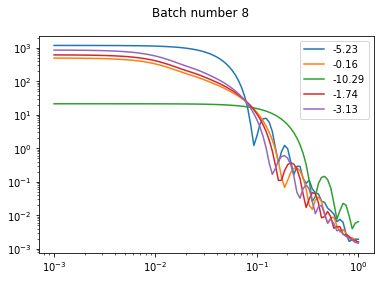

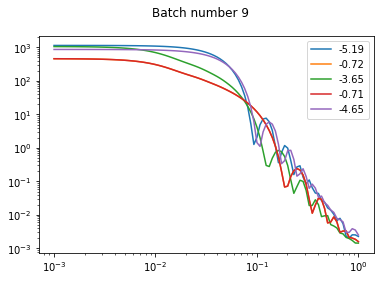

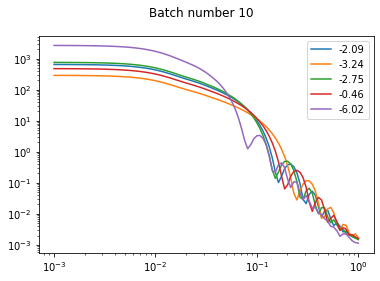

In [11]:
batch_number = torch.cat(
    [torch.zeros(N_INIT_SAMPLES), 
     torch.arange(1, N_ITERATIONS+1).repeat(BATCH_SIZE, 1).t().reshape(-1)]
).numpy()

for b in np.unique(batch_number):
    fig, ax = plt.subplots(1,1)
    fig.suptitle('Batch number %d'%b)
    for i in np.argwhere(batch_number==b).squeeze():
        if SPECTRA=='uvvis':
            ax.plot(expt[i][0], expt[i][1], label='%.2f'%expt[i][2])
        elif SPECTRA=='saxs':
            ax.loglog(expt[i][0], expt[i][1], label='%.2f'%expt[i][2])
    ax.legend()
    plt.show()